In [199]:
# Data Analysis
import pandas as pd
import numpy as np

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Data Prediction
from sklearn.preprocessing import LabelEncoder
import xgboost
from sklearn.metrics import mean_squared_error

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

import os
print(os.listdir("../input/inc-wlabels"))

['inc_wlabels.csv', 'inc_wo_labels.csv']


In [200]:
# Importing the dataset
dataset = pd.read_csv('../input/inc-wlabels/inc_wlabels.csv') # 111993
dt = pd.read_csv('../input/inc-wlabels/inc_wo_labels.csv') #73230

# Remove negative incomes
# dataset.drop(dataset.loc[dataset['Income in EUR']<0].index, inplace=True)

org_dt = dataset # 111827
# print(dataset.shape, dt.shape)
desc_X = dataset.describe()

y = org_dt.iloc[:,11].values.reshape(-1,1) # 111827
# y = np.log(y)

# Merge both labelled and unlabelles so they may be processed together
dataset = pd.concat([dataset,dt],axis='rows')
print(dataset.shape)
print(org_dt.shape)
print(y.shape)
desc_X
y

(185223, 12)
(111993, 12)
(111993, 1)


array([[ 61031.94416],
       [ 91001.32764],
       [157982.1767 ],
       ...,
       [289951.3294 ],
       [100046.5278 ],
       [145886.2885 ]])

In [201]:
dataset.nunique()

Instance             185223
Year of Record           40
Gender                    5
Age                     102
Country                 166
Size of City         165260
Profession             1351
University Degree         5
Wears Glasses             2
Hair Color                6
Body Height [cm]        156
Income in EUR        111991
dtype: int64

In [202]:
## Null Counting Fucntion
def null_values(df):
    
    sum_null = df.isnull().sum()
    total = df.isnull().count()
    percent_nullvalues = 100* sum_null / total 
    df_null = pd.DataFrame()
    df_null['Total'] = total
    df_null['Null_Count'] = sum_null
    df_null['Percent'] = round(percent_nullvalues,2)
    df_null = df_null.sort_values(by='Null_Count',ascending = False)
    df_null = df_null[df_null.Null_Count > 0]
    
    return(df_null)

print(null_values(org_dt))
null_values(dataset)

                    Total  Null_Count  Percent
Gender             111993        7432     6.64
University Degree  111993        7370     6.58
Hair Color         111993        7242     6.47
Age                111993         494     0.44
Year of Record     111993         441     0.39
Profession         111993         322     0.29


,Total,Null_Count,Percent
Income in EUR,185223,73230,39.54
Gender,185223,12294,6.64
University Degree,185223,12227,6.60
Hair Color,185223,12158,6.56
Age,185223,773,0.42
Year of Record,185223,736,0.40
Profession,185223,517,0.28


In [203]:
null_values(dataset)

# Fill missing values
dataset = dataset.fillna({
    'University Degree':'No',
    'Gender':'unknown',
    'Hair Color':'None',
    'Profession':'None',
    'Age': org_dt['Age'].mean(),
    'Year of Record': org_dt['Year of Record'].mean()
})

dataset['Gender'] = dataset['Gender'].replace({'0': 'unknown'})
dataset['Hair Color'] = dataset['Hair Color'].replace({'0': 'Unknown'})
dataset['University Degree'] = dataset['University Degree'].replace({'0': 'No'})

dataset.columns = ['Instance', 'Year of Record', 'Gender','Age','Country','Size of City','Profession','University Degree','Wears Glasses','Hair Color','Body Height cm','Income in EUR']
y = pd.DataFrame.from_records(y)

null_values(dataset)

,Total,Null_Count,Percent
Income in EUR,185223,73230,39.54


In [204]:
comm_profess = pd.Series()
comm_profess['comm_profess'] = pd.Series(' '.join(dataset['Profession']).lower().split()).value_counts()[:500].index.tolist()
comm_profess['comm_profess'].remove('and')
comm_profess['comm_profess'].remove('&')
comm_profess['comm_profess'].remove('-')

def replaceProf(x):
    arr = x.split() 
    for p in range(0,len(comm_profess['comm_profess'])) :
        for a in range(0,len(arr)):
            if (comm_profess['comm_profess'][p]==arr[a]):
                # print(x,comm_profess['comm_profess'][p])
                x = comm_profess['comm_profess'][p]
                return comm_profess['comm_profess'][p]
            else:
                x = 'worker'

# Extracts the most common words from the Profession

"""
dataset['Profession'] = dataset['Profession'].apply(lambda x: replaceProf(x))
# org_dt['Profession'].apply(lambda x: replaceProf(x))
dataset['Profession'].to_csv('datprof.csv')
"""


"\ndataset['Profession'] = dataset['Profession'].apply(lambda x: replaceProf(x))\n# org_dt['Profession'].apply(lambda x: replaceProf(x))\ndataset['Profession'].to_csv('datprof.csv')\n"

In [205]:
dataset['Uni Degree'] = pd.Categorical(dataset['University Degree']).rename_categories({'No': 0, 'Bachelor': 1,'Master':2,'PhD':3})
dataset['Uni Degree'].value_counts()
dataset['Uni Degree'] = dataset['Uni Degree'].astype('int64')
dataset['Uni Degree']


0        1
1        2
2        3
3        0
4        0
        ..
73225    1
73226    0
73227    2
73228    2
73229    2
Name: Uni Degree, Length: 185223, dtype: int64

In [206]:
# Creating Dummy Variables
dummy_gender = (pd.get_dummies(dataset['Gender'])).iloc[:, :-1] # 4 gender
dummy_country = pd.get_dummies(dataset['Country']).iloc[:, :-1] #159 countries
dummy_profession = pd.get_dummies(dataset['Profession']).iloc[:, :-1] # 1339 professions
# dummy_degree = pd.get_dummies(dataset['University Degree']).iloc[:, :-1] # 4 degrees 
dummy_haircolor = pd.get_dummies(dataset['Hair Color']).iloc[:, :-1] # 5 hair


dataset['CitySizeLog'] = np.log(dataset['Size of City'])
dataset['IncomeLog'] = np.log(dataset['Income in EUR'])
# dataset['Year of Record'] = dataset['Year of Record'].apply(lambda x: x - 1980)
dataset['Year of Record']

"""dummy_gender = (pd.get_dummies(dataset['Gender'])) # 4 gender
dummy_country = pd.get_dummies(dataset['Country']) #159 countries
dummy_profession = pd.get_dummies(dataset['Profession']) # 1339 professions
# dummy_degree = pd.get_dummies(dataset['University Degree']).iloc[:, :-1] # 4 degrees 
dummy_haircolor = pd.get_dummies(dataset['Hair Color']) # 5 hair"""

"dummy_gender = (pd.get_dummies(dataset['Gender'])) # 4 gender\ndummy_country = pd.get_dummies(dataset['Country']) #159 countries\ndummy_profession = pd.get_dummies(dataset['Profession']) # 1339 professions\n# dummy_degree = pd.get_dummies(dataset['University Degree']).iloc[:, :-1] # 4 degrees \ndummy_haircolor = pd.get_dummies(dataset['Hair Color']) # 5 hair"

In [207]:
org_dt['Country']

0                      Belarus
1                    Singapore
2                       Norway
3                         Cuba
4         United Arab Emirates
                  ...         
111988                Honduras
111989                 Tunisia
111990               Sri Lanka
111991                 Denmark
111992      State of Palestine
Name: Country, Length: 111993, dtype: object

In [208]:
y.columns = ['Income']
countryAves = pd.concat([org_dt['Country'],
                        org_dt['Size of City'],
                        org_dt['Age'],
                        y['Income']], axis=1)

b = countryAves.groupby('Country').mean()
b = b.rename({ 'Size of City':'CountryAveCitySize',
               'Income':'CountryAveEarning',
               'Age':'CountryAveAge'}, axis=1)

b

,CountryAveCitySize,CountryAveAge,CountryAveEarning
Country,,,
Afghanistan,6.373037e+05,39.285714,8.879485e+05
Albania,8.724576e+05,37.535176,3.093651e+05
Algeria,9.825891e+05,26.285714,5.836315e+05
Angola,1.190360e+06,35.792453,6.436873e+05
Argentina,1.019613e+06,30.833333,1.104589e+06
...,...,...,...
Venezuela,8.810847e+05,36.173469,5.409539e+05
Vietnam,9.138400e+04,31.000000,3.213682e+06
Yemen,1.002108e+06,36.551724,5.469064e+05


In [209]:
# Empty spaces can be added in later by autoclean...
X = org_dt['Country']
#X = pd.merge(X, b, on='Profession', how='left', sort=False)
X = X.reset_index().merge(b, on='Country', how="left").set_index('index')
X = X.drop('Country', axis=1)
X

,CountryAveCitySize,CountryAveAge,CountryAveEarning
index,,,
0,804670.998106,37.633159,33116.813053
1,952551.623932,38.180011,56285.026965
2,869125.012500,38.064686,87116.830844
3,789873.203729,37.777547,100607.155049
4,836528.687774,37.061125,42773.138452
...,...,...,...
111988,840913.833568,37.213712,40478.734970
111989,841826.691016,37.655434,135724.673788
111990,994180.887805,38.240196,429979.701959


In [210]:
prof = org_dt['Profession'].str.lower()
X = pd.concat([X, prof], axis=1)
professionAves = pd.concat([org_dt['Profession'].str.lower(),
                            org_dt['Size of City'],
                            org_dt['Age'],
                            X['CountryAveCitySize'],
                            X['CountryAveEarning'],
                            X['CountryAveAge'],
                            y['Income']], axis=1)

c = professionAves.groupby('Profession').mean().reset_index()
c = c.rename({ 'Size of City':'ProfessionAveCitySize',
               'Income':'ProfessionAveEarning',
               'Age':'ProfessionAveAge',
             'CountryAveAge':'CountryProfAveAge',
             'CountryAveEarning':'CountryProfAveEarning',
             'CountryAveAge':'CountryProfAveAge'}, axis=1)

X = X.reset_index().merge(c, on='Profession', how="left").set_index('index')
X = X.drop('Profession', axis=1)
X

,CountryAveCitySize_x,CountryAveAge,CountryAveEarning,ProfessionAveCitySize,ProfessionAveAge,CountryAveCitySize_y,CountryProfAveEarning,CountryProfAveAge,ProfessionAveEarning
index,,,,,,,,,
0,804670.998106,37.633159,33116.813053,5.690987e+05,39.706667,830823.825962,108403.292627,37.247088,151466.154967
1,952551.623932,38.180011,56285.026965,1.319762e+06,37.440594,831883.473583,114493.990230,37.291437,133995.974029
2,869125.012500,38.064686,87116.830844,7.289293e+05,36.838542,835229.543686,106792.495712,37.318456,117286.626556
3,789873.203729,37.777547,100607.155049,1.457333e+06,34.608696,842784.843305,95755.675523,37.389970,56144.047562
4,836528.687774,37.061125,42773.138452,1.007441e+06,37.871166,837108.021998,93881.829786,37.368673,88209.535957
...,...,...,...,...,...,...,...,...,...
111988,840913.833568,37.213712,40478.734970,9.117592e+05,35.419753,834623.977935,99084.553195,37.297375,59594.668358
111989,841826.691016,37.655434,135724.673788,1.050179e+06,37.561983,832605.251928,111781.435088,37.442488,135245.179782
111990,994180.887805,38.240196,429979.701959,1.101049e+06,36.674286,832521.726789,114335.205695,37.319183,98273.245191


In [211]:
professionAves
c

,Profession,ProfessionAveCitySize,ProfessionAveAge,CountryAveCitySize,CountryProfAveEarning,CountryProfAveAge,ProfessionAveEarning
0,.net developer,1.098149e+06,33.200000,826409.729624,122657.951457,36.748935,194211.087120
1,.net software developer,1.012420e+06,31.000000,808918.400061,88529.179164,37.385940,63816.304430
2,accessibility outreach coordinator,8.526100e+04,33.000000,800567.723309,64396.592903,36.960718,17204.790070
3,accessibility program manager,1.960634e+06,33.500000,779880.022599,31732.578983,37.378408,37212.198420
4,account executive,4.966050e+05,20.000000,881084.653061,540953.871906,36.173469,644524.183000
...,...,...,...,...,...,...,...
1323,workforce planning intern,8.511467e+05,39.875000,838281.283661,100872.505565,37.345718,164529.109083
1324,writer,7.228182e+05,34.781250,846329.868988,119371.558010,37.372702,170922.079052
1325,x-ray technician,8.561219e+05,36.862069,831321.006622,125210.072567,37.307195,219642.858725
1326,yardmaster,2.085673e+06,39.428571,856728.115393,72191.563054,37.166622,96012.661454


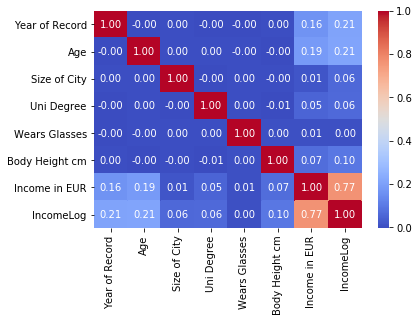

In [212]:
import seaborn as sns
# Identify Numeric features
numeric_features = ['Year of Record','Age','Size of City','Uni Degree','Wears Glasses','Body Height cm','Income in EUR','IncomeLog']

# Identify Categorical features
cat_features = ['Gender','Country','Profession','Hair Color']

# Correlation matrix between numerical values
g = sns.heatmap(dataset[numeric_features].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

In [213]:
X

,CountryAveCitySize_x,CountryAveAge,CountryAveEarning,ProfessionAveCitySize,ProfessionAveAge,CountryAveCitySize_y,CountryProfAveEarning,CountryProfAveAge,ProfessionAveEarning
index,,,,,,,,,
0,804670.998106,37.633159,33116.813053,5.690987e+05,39.706667,830823.825962,108403.292627,37.247088,151466.154967
1,952551.623932,38.180011,56285.026965,1.319762e+06,37.440594,831883.473583,114493.990230,37.291437,133995.974029
2,869125.012500,38.064686,87116.830844,7.289293e+05,36.838542,835229.543686,106792.495712,37.318456,117286.626556
3,789873.203729,37.777547,100607.155049,1.457333e+06,34.608696,842784.843305,95755.675523,37.389970,56144.047562
4,836528.687774,37.061125,42773.138452,1.007441e+06,37.871166,837108.021998,93881.829786,37.368673,88209.535957
...,...,...,...,...,...,...,...,...,...
111988,840913.833568,37.213712,40478.734970,9.117592e+05,35.419753,834623.977935,99084.553195,37.297375,59594.668358
111989,841826.691016,37.655434,135724.673788,1.050179e+06,37.561983,832605.251928,111781.435088,37.442488,135245.179782
111990,994180.887805,38.240196,429979.701959,1.101049e+06,36.674286,832521.726789,114335.205695,37.319183,98273.245191


In [214]:
# Dataset copy to ocmpare 
dataset2 = dataset

#Drop categorical columns
dataset2 = dataset2.drop(['Gender','University Degree','IncomeLog','Country','Profession','Size of City','Hair Color','Instance','Wears Glasses','Income in EUR'],axis='columns')
# dataset2 = dataset2.drop(['Gender','Country','Profession','University Degree','Hair Color','Instance'],axis='columns')

# Merge dummy variables
merged  = pd.concat([dataset2,dummy_gender],axis="columns")
# merged  = pd.concat([dataset2,dummy_gender,dummy_degree,dummy_haircolor],axis="columns")

merged = pd.concat([merged[0:111993],X],axis=1)
merged

,Year of Record,Age,Body Height cm,Uni Degree,CitySizeLog,female,male,other,CountryAveCitySize_x,CountryAveAge,CountryAveEarning,ProfessionAveCitySize,ProfessionAveAge,CountryAveCitySize_y,CountryProfAveEarning,CountryProfAveAge,ProfessionAveEarning
0,1997.0,41.0,193,1,14.030565,0,0,0,804670.998106,37.633159,33116.813053,5.690987e+05,39.706667,830823.825962,108403.292627,37.247088,151466.154967
1,1996.0,41.0,186,2,14.287702,0,0,1,952551.623932,38.180011,56285.026965,1.319762e+06,37.440594,831883.473583,114493.990230,37.291437,133995.974029
2,2018.0,28.0,170,3,14.076348,0,0,1,869125.012500,38.064686,87116.830844,7.289293e+05,36.838542,835229.543686,106792.495712,37.318456,117286.626556
3,2006.0,33.0,171,0,13.530363,0,0,1,789873.203729,37.777547,100607.155049,1.457333e+06,34.608696,842784.843305,95755.675523,37.389970,56144.047562
4,2010.0,46.0,188,0,11.465719,1,0,0,836528.687774,37.061125,42773.138452,1.007441e+06,37.871166,837108.021998,93881.829786,37.368673,88209.535957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111988,1980.0,29.0,135,0,12.232101,1,0,0,840913.833568,37.213712,40478.734970,9.117592e+05,35.419753,834623.977935,99084.553195,37.297375,59594.668358
111989,2006.0,36.0,147,2,13.828255,1,0,0,841826.691016,37.655434,135724.673788,1.050179e+06,37.561983,832605.251928,111781.435088,37.442488,135245.179782
111990,1993.0,36.0,153,2,11.016134,1,0,0,994180.887805,38.240196,429979.701959,1.101049e+06,36.674286,832521.726789,114335.205695,37.319183,98273.245191
111991,2019.0,54.0,190,0,13.651390,0,0,1,867784.190106,37.725293,61135.778415,1.173424e+06,37.238889,835985.511602,101666.245926,37.279530,114634.753398


In [215]:
dataset['Profession'] 

0                            steel workers
1                   safe event coordinator
2             receivables/payables analyst
3                          fleet assistant
4                             lead trainer
                       ...                
73225                   payroll supervisor
73226             purchasing agent - buyer
73227    neigborhood resiliency specialist
73228    it infrastructure project manager
73229                   materials engineer
Name: Profession, Length: 185223, dtype: object

In [216]:
# Finding Outliers, +0.7 or higher: Very strong positive relationship

"""
org_dt = merged.iloc[0:111827,:]
org_dt = pd.DataFrame.from_records(org_dt)
org_dt['IncomeLog'] = np.log(org_dt['Income in EUR'])

corr = org_dt.corr().abs()
corr.IncomeLog[corr.IncomeLog >= 0.005].sort_values(ascending=False)
"""

"\norg_dt = merged.iloc[0:111827,:]\norg_dt = pd.DataFrame.from_records(org_dt)\norg_dt['IncomeLog'] = np.log(org_dt['Income in EUR'])\n\ncorr = org_dt.corr().abs()\ncorr.IncomeLog[corr.IncomeLog >= 0.005].sort_values(ascending=False)\n"

In [217]:
"""org_dt.plot.scatter(x='Age', y='IncomeLog', color = 'green')
plt.show()"""


"org_dt.plot.scatter(x='Age', y='IncomeLog', color = 'green')\nplt.show()"

In [218]:
# Splitting the dataset into the Training set and Test set manually

"""X_train = merged.iloc[0:78000,:] 
X_test = merged.iloc[78000:111827,:]
y_train = y[0:78000]
y_test = y[78000:111827]"""


X_train = merged.iloc[0:111993,:] 
X_test = merged.iloc[100000:111993,:]
y_train = y[0:111993]
y_test = y[100000:111993]


In [219]:
"""
xgb = xgboost.XGBRegressor(colsample_bytree=0.8, subsample=0.5,
                             learning_rate=0.05, max_depth=8, 
                             min_child_weight=2.8, n_estimators=1000,
                             reg_alpha=0.3, reg_lambda=0.75, gamma=0.01, 
                             silent=1, random_state =7, nthread = -1)
"""

xgb = xgboost.XGBRegressor(colsample_bytree=0.4,
                   eval_metric='rmse',
                 gamma=0.01,
                   nthread=-1,
                 learning_rate=0.05,
                 max_depth=4, 
                 min_child_weight=1.8,
                 n_estimators=3000,                                                     
                 reg_alpha=0.3,
                 reg_lambda=0.75,
                 subsample=0.5,
                 seed=42)

"""# Fitting Simple Linear Regression to the Training set
from sklearn.linear_model import LinearRegression
xgb = LinearRegression()"""

xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
y_t2 = xgb.predict(X_train)

[23:21:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


KeyboardInterrupt: 

In [ ]:
RMSE = np.sqrt(mean_squared_error(y_train, y_t2))
print(np.sqrt(mean_squared_error(xgb_pred, y_test)))
print(RMSE.round(4))
score = xgb.score(X_test,y_test)
print(score)

In [ ]:
y_t2

In [ ]:
y_dt_pred = xgb.predict(merged.iloc[111827:,:])
corrected_pred = y_dt_pred
for i in range(0,len(corrected_pred)):
    if corrected_pred[i] < 0:
        corrected_pred[i] = corrected_pred[i]*(-1)
        
corrected_pred.flatten()        
y_dt_pred.flatten()

In [ ]:
submission = pd.DataFrame({
        "Instance": dt['Instance'],
        "Income": y_dt_pred.flatten()
    })
submission = pd.DataFrame.from_records(submission)
submission.to_csv('submission.csv')

submission_corr = pd.DataFrame({
        "Instance": dt['Instance'],
        "Income": corrected_pred.flatten()
    })
submission_corr = pd.DataFrame.from_records(submission)
submission.to_csv('submission_corr.csv')
print(submission_corr)

In [ ]:
merged

In [ ]:
dt['Instance'].values
submission